In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('../..')
import pandas as pd
from model import VAE
from Model import input_pipeline
from Plots import style
from Model.results import get_df, get_stats, final_plot
from joblib import load
import seaborn as sns

2024-06-13 13:45:08.842105: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 13:45:08.888689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 13:45:08.888736: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 13:45:08.889965: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-13 13:45:08.897816: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-13 13:45:08.898950: I tensorflow/core/platform/cpu_feature_guard.cc:1

# Helper functions

In [2]:
def sample_normal(num_examples_to_generate, model):
    latent_dim = model.latent_dim
    random_mean = tf.random.normal(mean = 0, stddev=1 ,
        shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(mean = 0, stddev=1,
        shape=[num_examples_to_generate, latent_dim])
    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions
    
def plus_encode_data(data):
    data = tf.reshape(data, shape=(data.shape[0], -1))
    mean_data = tf.reduce_mean(data, axis=1, keepdims=True)
    need_change = tf.cast(mean_data < 0.5, data.dtype)
    data = data * (1 - 2 * need_change) + need_change
    data = tf.reshape(data, shape=(-1, 32, 32, 1))
    return data   
    
def random_swap(data):
    data = tf.reshape(data, shape = (data.shape[0], -1))
    swap_mask = 2 * (np.random.random(size = (data.shape[0], 1)) > 0.5) - 1
    data = tf.multiply(data, swap_mask)
    data = tf.reshape(data, shape = (-1, 32, 32, 1))
    return data

def sample_empirical(num_examples_to_generate, model, means, vars):
    latent_dim = model.latent_dim
    mean = tf.reduce_mean(means, axis = 0)
    std_mean = tf.math.reduce_std(means, axis = 0)
    var = tf.reduce_mean(vars, axis = 0)
    std_var = tf.math.reduce_std(vars, axis = 0)

    random_mean = tf.random.normal(mean = mean, stddev=std_mean,
        shape=[num_examples_to_generate, latent_dim])
    log_var = tf.random.normal(mean = var, stddev=std_var,
        shape=[num_examples_to_generate, latent_dim])
    z = model.reparameterize(random_mean, log_var)
    predictions = model.sample(z)
    return predictions
    
def sample_gm(num_examples_to_generate, vae, gm_mean, gm_var):
    random_mean, _ = gm_mean.sample(num_examples_to_generate)
    log_var, _ = gm_var.sample(num_examples_to_generate)
    random_mean = tf.cast(random_mean, tf.float32)
    log_var = tf.cast(log_var, tf.float32)
    z = vae.reparameterize(random_mean, log_var)
    predictions = vae.sample(z)
    return predictions

def load_model_at_T(t, folder, latent_dim = 200):
    model = VAE(latent_dim)
    dummy_input = tf.zeros((1, 32, 32, 1))
    model(dummy_input)
    model.load_weights(f'Results/{folder}/{t:.1f}/vae{t:.1f}.h5')
    gm_mean = load(f'Results/{folder}/{t:.1f}/gm_means.pkl')
    gm_var = load(f'Results/{folder}/{t:.1f}/gm_vars.pkl')
    return model, gm_mean, gm_var

## Models dictionary

In [3]:
temps = np.arange(2.0, 3.05, 0.1)
titles = [f"Temperature: {t:.1f}" for t in temps]
folder = "22-03-2024"
models = {t: load_model_at_T(t, folder) for t in temps}

# Compare with monte carlo

## Mean Var expermients

In [4]:
temp = 3.0
model, _, _ = load_model_at_T(temp, folder)
batch_size = 5000

trainset_path = f"../../GetData/Python/Data/Data{temp:.1f}.tfrecord"
train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)

testset_path = f"../../GetData/Python/Data/TestData{temp:.1f}.tfrecord"
test_set = input_pipeline.dataset_tfrecord_pipeline(testset_path, flatten=False, batch_size=batch_size)

# data mc trainset
data_mc = next(iter(train_set))
data_plus = plus_encode_data(data_mc)
encoded = model.encode(data_plus)
data_mc = 2 * data_mc - 1
df_monte_carlo = get_df(data_mc)

# logvar, mean
means, vars =  encoded
means = means.numpy()
vars = vars.numpy()

# data testset encoded
data_test = next(iter(test_set))
test_reconstructed = model(data_test)
test_sample = 2 * np.random.binomial(1, test_reconstructed) - 1
df_test = get_df(test_sample)

# empirical logvar and mean
sample_data_std = sample_empirical(batch_size, model, means, vars)
sample_data_std = 2 * np.random.binomial(1, sample_data_std) - 1
spin_sample = random_swap(sample_data_std)
df_sampled_std = get_df(sample_data_std)

# normal logvar and mean
sample_data = sample_normal(batch_size, model)
spin_sample = 2 * np.random.binomial(1, sample_data) - 1
spin_sample = random_swap(spin_sample)
df_sampled = get_df(spin_sample)

2024-06-13 13:45:16.294927: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-06-13 13:45:16.479361: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-06-13 13:45:16.682082: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-06-13 13:45:16.848623: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 655360000 exceeds 10% of free system memory.
2024-06-13 13:45:17.183850: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 327680000 exceeds 10% of free system memory.


In [5]:
df_sampled['Type'] = 'Sampled from N(0,1)'
df_monte_carlo['Type'] = 'Monte Carlo'
df_test['Type'] = 'Testset decoded'
df_sampled_std['Type'] = 'Sampled from empirical '
df = pd.concat([df_sampled, df_monte_carlo, df_test, df_sampled_std])

In [6]:
figsize = style.get_figsize("fig")

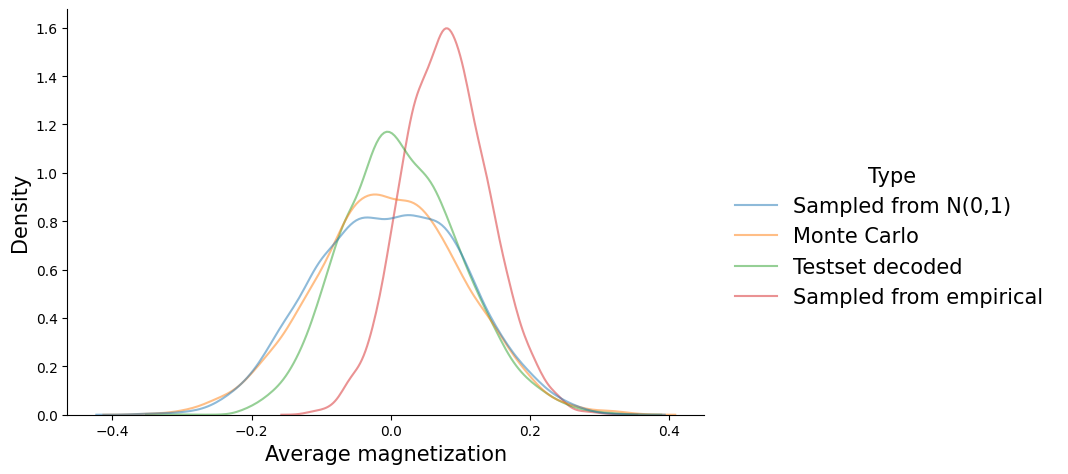

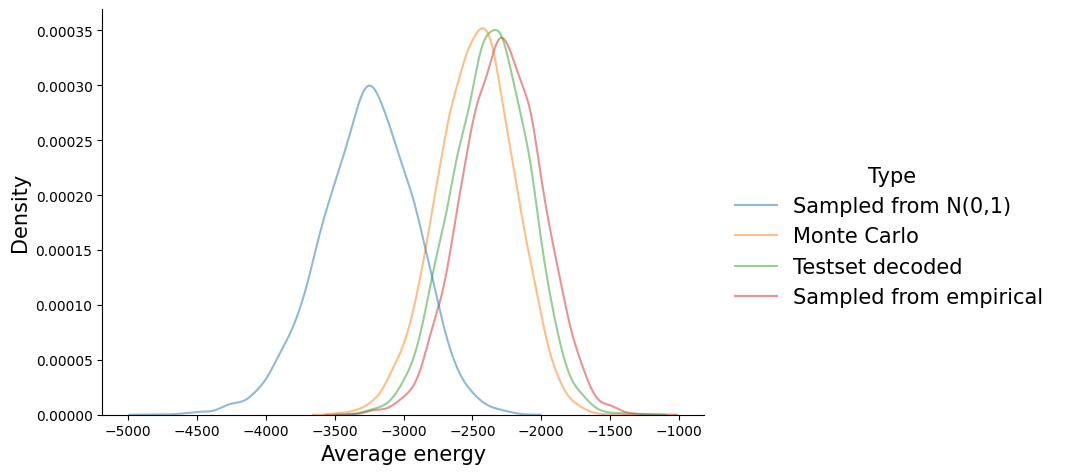

In [7]:
g = sns.displot(data=df, x='Magnetization', kind='kde', hue = 'Type', alpha=0.5, height=figsize[1], aspect=figsize[0]/figsize[1])  # 10 inches wide
plt.xlabel('Average magnetization')
plt.savefig(f"Results/{folder}/plots/methods_magnetization.svg")

g = sns.displot(data=df, x='Energy', kind='kde', hue = 'Type', alpha=0.5, height=figsize[1], aspect=figsize[0]/figsize[1])  # 20 inches wide
plt.xlabel('Average energy')
plt.savefig(f"Results/{folder}/plots/methods_energy.svg")

## Kolmogorov-Smirnov test

In [8]:
from scipy import stats

def ks_test(data, means = None, variances = None):
    if means is None:
        means = np.mean(data, axis=0)
    if variances is None:
        variances = np.var(data, axis=0)
    ks_results = [stats.kstest(data[:, i], 'norm', args=(means[i], np.sqrt(variances[i]))).pvalue for i in range(data.shape[1])]
    return ks_results

In [9]:
import matplotlib.pyplot as plt

tick_size = 15

# Assuming ks_means and ks_variances are your data
ks_means = ks_test(means)
ks_variances = ks_test( vars)

# Assuming ks_means and ks_variances are your data
ks_means_standard = ks_test(means, np.zeros(shape=200), np.ones(shape=200))
ks_variances_standard = ks_test(vars, np.zeros(shape=200), np.ones(shape=200))

# Set the style
half_fig = style.get_figsize("half_fig")

# Create a figure for the first histogram
plt.figure(figsize=half_fig)
plt.hist(ks_means, color='green')
plt.tight_layout()
plt.savefig(f"Results/{folder}/plots/ks_test_means_empirical_normal.svg")
plt.close()

# Create a figure for the second histogram
plt.figure(figsize=half_fig)
plt.hist(ks_variances, color='orange')
plt.tight_layout()
plt.savefig(f"Results/{folder}/plots/ks_test_logvariances_empirical_normal.svg")
plt.close()

# Create a figure for the third histogram
plt.figure(figsize=half_fig)
plt.hist(ks_means_standard, bins=10, color='green')
plt.tight_layout()
plt.savefig(f"Results/{folder}/plots/ks_test_means_N01.svg")
plt.close()

# Create a figure for the fourth histogram
plt.figure(figsize=half_fig)
plt.hist(ks_variances_standard, bins=10, color='orange')
plt.xlim(-.05,1)
plt.tight_layout()
plt.savefig(f"Results/{folder}/plots/ks_test_logvariances_N01.svg")
plt.close()

## Data

In [10]:
data_list = []
for temp in temps:

    trainset_path = f"../../GetData/Python/Data/Data{temp:.1f}.tfrecord"
    batch_size = 100
    train_set = input_pipeline.dataset_tfrecord_pipeline(trainset_path, flatten=False, batch_size=batch_size)
    
    vae, gm_mean, gm_var = models[temp]
    data_mc = []
    data_normal = []
    data_gm = []
    for data in train_set:
        data_mc.append(data)
        data_normal.append(sample_normal(batch_size, vae))
        data_gm.append(sample_gm(batch_size, vae, gm_mean, gm_var))
    
    data_mc = np.concatenate(data_mc)
    data_normal = np.concatenate(data_normal)
    data_gm = np.concatenate(data_gm)
    
    data_mc = 2 * data_mc - 1
    data_gm = 2 * np.random.binomial(1, data_gm) - 1
    data_normal = 2 * np.random.binomial(1, data_normal) - 1

    # Monte Carlo
    df_monte_carlo = get_df(data_mc)
    mc_stats = get_stats(df_monte_carlo, temp)
    mc_stats.extend((temp, "Monte Carlo"))


    # VAE normal
    data_normal = random_swap(data_normal)
    df_sampled = get_df(data_normal)
    normal_stats = get_stats(df_sampled, temp)
    normal_stats.extend((temp, "Sampled VAE normal"))
    
    # VAE gm
    data_gm = random_swap(data_gm)
    df_sampled = get_df(data_gm)
    gm_stats = get_stats(df_sampled, temp)
    gm_stats.extend((temp, "Sampled VAE gm"))
    
    # Append to data list
    data_list.append(mc_stats)
    data_list.append(gm_stats)
    data_list.append(normal_stats)

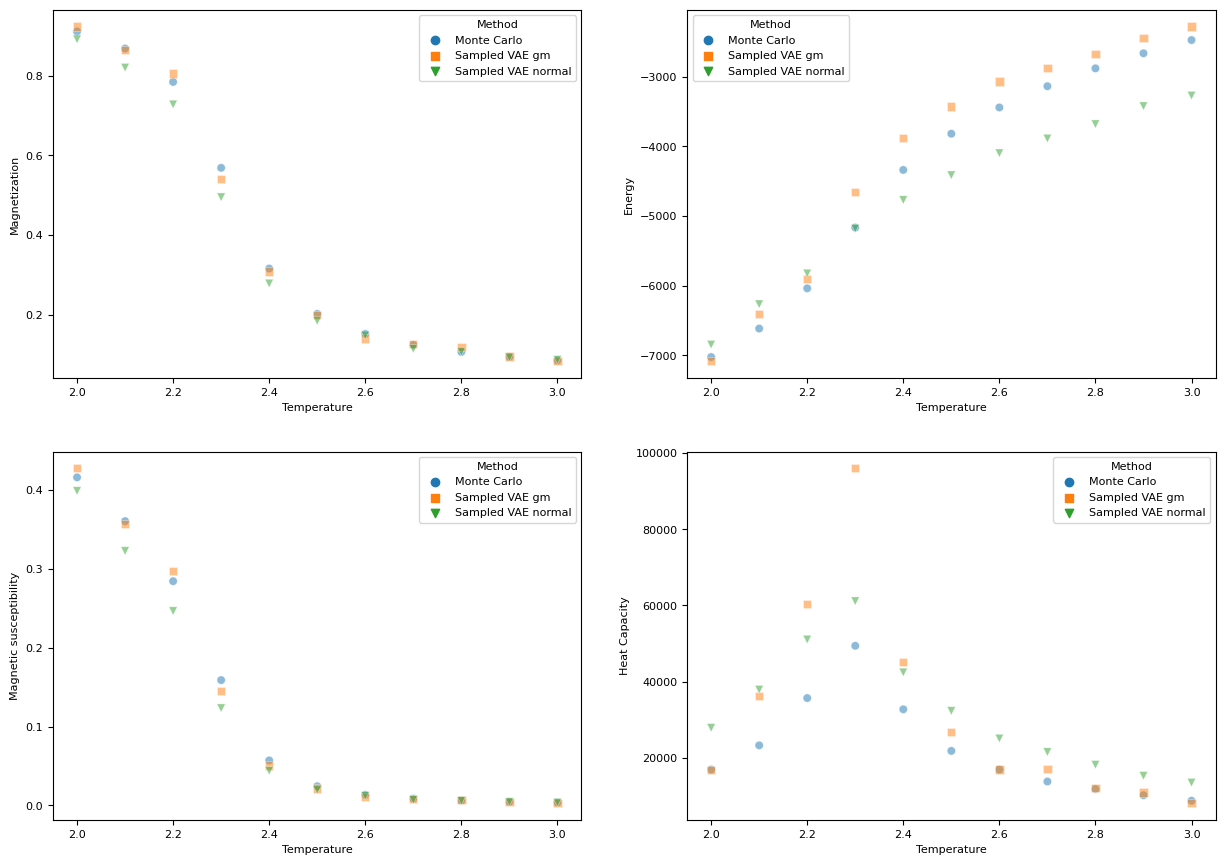

In [16]:
df = pd.DataFrame(data_list, columns=['Magnetization', 'Energy', 'Magnetic susceptibility', 'Heat Capacity', 'Temperature', 'Method'])
final_plot(df)
plt.savefig(f"Results/{folder}/plots/final_vae.svg")

## Samples

In [10]:
temp_label = list(zip(temps, titles))
long_fig = style.get_figsize("long_fig")

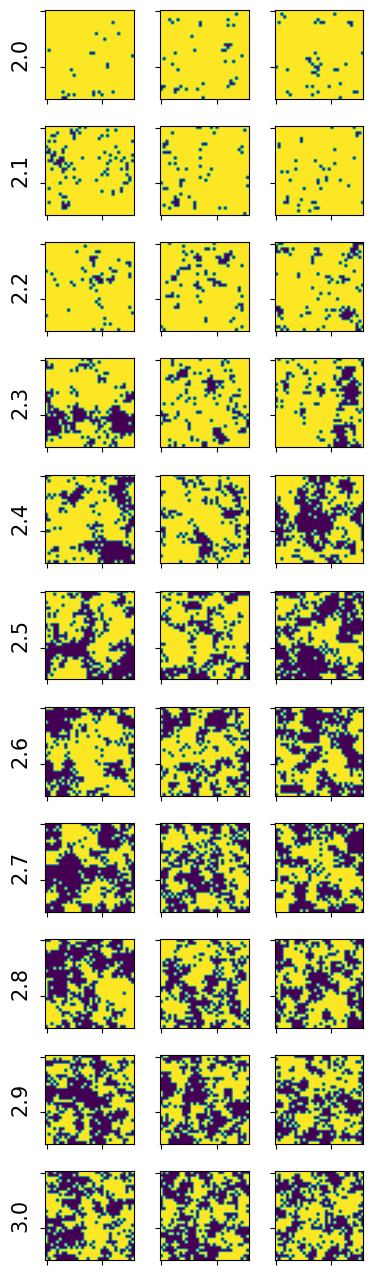

In [23]:
import numpy as np
import matplotlib.pyplot as plt

def plot_samples(folder, temp_label, name):
    nrpws = len(temp_label)
    ncols = 3
    fig, axes = plt.subplots(nrows=nrpws, ncols=ncols, figsize=long_fig)
    plt.subplots_adjust(top=0.96)
    for i, ax_row in enumerate(axes):
        temp, label = temp_label[i]
        ax_row[0].set_ylabel(label.split()[-1], rotation=90, size=15)
        vae, gm_mean, gm_var = models[temp]
        predictions = sample_gm(ncols, vae, gm_mean, gm_var)
        for j, ax in enumerate(ax_row):
            ax.yaxis.set_ticklabels([])
            ax.xaxis.set_ticklabels([])
            spins = np.random.binomial(1, predictions[j, :, :])
            ax.imshow(spins, vmin=0, vmax=1)
    plt.tight_layout()
    plt.savefig(f"Results/{folder}/plots/samples_{name}.svg")

plot_samples(folder, temp_label, "all")
